## Overview

The `AdaptiveResonance.jl` package has several ways of handling options for ART modules.
These methods are meant to give maximum flexibility to the user for sharing and interpreting options, which themselves vary between each module.

!!! note
    For more info on options in ART modules, see the guide in the docs on ART options.

## ART Options

To get a feel for the ART options system, we will inspect different options and their instantiation methods.

### Inspection

First, we load `AdaptiveResonance`:

In [1]:
using AdaptiveResonance

Every ART module has a default constructor, which can be instantiated in the usual way:

In [2]:
# Create a FuzzyART module with default options
my_fuzzyart = FuzzyART()
typeof(my_fuzzyart)

FuzzyART

Within every ART module is a [Parameters.jl](https://github.com/mauro3/Parameters.jl) struct named `opts` containing the options for the module

In [3]:
# Check the FuzzyART options
my_fuzzyart.opts

opts_FuzzyART
  rho: Float64 0.6
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool true
  gamma_normalization: Bool false


Note that the options here have the type `opts_FuzzyART`.
This nomenclature is used throughout the module to indicate an options type associated with an ART module.
For example, the options for a DDVFA module are `opts_DDVFA`:

In [4]:
# Create a DDVFA module and check the type of the options
my_ddvfa = DDVFA()
typeof(my_ddvfa.opts)

opts_DDVFA

In fact, we can create an instance of these options with a default constructor:

In [5]:
# Create a separate options struct
my_fuzzyart_opts = opts_FuzzyART()

opts_FuzzyART
  rho: Float64 0.6
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool true
  gamma_normalization: Bool false


In addition to the default constructor, we can construct ART modules by instantiating these options and passing them to the module during construction:

In [6]:
# Instantiate an ART module by passing our options
my_fuzzyart = FuzzyART(my_fuzzyart_opts)
my_other_fuzzyart = FuzzyART(my_fuzzyart_opts)

FuzzyART(opts_FuzzyART
  rho: Float64 0.6
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool true
  gamma_normalization: Bool false
, DataConfig(false, Float64[], Float64[], 0, 0), 0.0, Int64[], Float64[], Float64[], Matrix{Float64}(undef, 0, 0), Int64[], 0, 0)

### Specifying Options

Now to the good stuff: because of the behavior of the `Parameters.jl` type, each option has a default value that we can modify during instantiation with keyword arguments:

In [7]:
# Change some of the default FuzzyART options
my_fuzzyart_opts = opts_FuzzyART(
    rho=0.6,
    gamma_normalization=true
)
my_fuzzyart = FuzzyART(my_fuzzyart_opts)

FuzzyART(opts_FuzzyART
  rho: Float64 0.6
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool true
  gamma_normalization: Bool true
, DataConfig(false, Float64[], Float64[], 0, 0), 0.0, Int64[], Float64[], Float64[], Matrix{Float64}(undef, 0, 0), Int64[], 0, 0)

As some syntactic sugar, we can pass these keyword arguments directly to the module during instantiation if we have no need to share option structs:

In [8]:
# Pass these keyword arguments to the module directly
my_fuzzyart = FuzzyART(
    rho=0.6,
    gamma_normalization=true
)

FuzzyART(opts_FuzzyART
  rho: Float64 0.6
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool true
  gamma_normalization: Bool true
, DataConfig(false, Float64[], Float64[], 0, 0), 0.0, Int64[], Float64[], Float64[], Matrix{Float64}(undef, 0, 0), Int64[], 0, 0)

Before training, we can also instantiate the model and alter the options afterward:

In [9]:
my_fuzzyart = FuzzyART()
my_fuzzyart.opts.rho=0.6

0.6

!!! note
    All ART modules are designed to use this options struct internally when the parameters are needed.
    It is possible to change these parameters in the middle of training and evaluation, but some algorithmic instability may occur.

## Comparison

To see the effect that changing these parameters has on the modules, we can train and test them side-by-side.

We begin with importing AdaptiveResonance for the ART modules and MLDatasets for some data utilities.

In [10]:
using MLDatasets        # Iris dataset
using DataFrames        # DataFrames, necessary for MLDatasets.Iris()
using MLDataUtils       # Shuffling and splitting
using Printf            # Formatted number printing
using MultivariateStats # Principal component analysis (PCA)
using Plots             # Plotting frontend
gr()                    # Use the default GR backend explicitly

Plots.GRBackend()

We will download the Iris dataset for its small size and benchmark use for clustering algorithms.

In [11]:
# Get the iris dataset
iris = Iris(as_df=false)
# Manipulate the features and labels into a matrix of features and a vector of labels
features, labels = iris.features, iris.targets

([5.1 4.9 … 6.2 5.9; 3.5 3.0 … 3.4 3.0; 1.4 1.4 … 5.4 5.1; 0.2 0.2 … 2.3 1.8], InlineStrings.String15["Iris-setosa" "Iris-setosa" … "Iris-virginica" "Iris-virginica"])

Because the MLDatasets package gives us Iris labels as strings, we will use the `MLDataUtils.convertlabel` method with the `MLLabelUtils.LabelEnc.Indices` type to get a list of integers representing each class:

In [12]:
labels = convertlabel(LabelEnc.Indices{Int}, vec(labels))
unique(labels)

3-element Vector{Int64}:
 1
 2
 3

Next, we will create a train/test split with the `MLDataUtils.stratifiedobs` utility:

In [13]:
(X_train, y_train), (X_test, y_test) = stratifiedobs((features, labels))

(([5.2 5.0 … 5.6 5.9; 4.1 3.6 … 2.7 3.0; 1.5 1.4 … 4.2 5.1; 0.1 0.2 … 1.3 1.8], [1, 1, 3, 2, 3, 2, 2, 3, 2, 3  …  2, 3, 3, 1, 2, 1, 1, 3, 2, 3]), ([4.8 5.1 … 4.9 7.0; 3.4 3.8 … 3.1 3.2; 1.6 1.9 … 1.5 4.7; 0.2 0.4 … 0.1 1.4], [1, 1, 2, 3, 1, 2, 3, 1, 1, 1  …  2, 1, 3, 2, 3, 2, 2, 1, 1, 2]))

Now we can create several FuzzyART modules with different options.

In [14]:
# Create two FuzzyARTs with different vigilance values and suppressing logging messages
rho_1 = 0.5
rho_2 = 0.7
my_fuzzyart_1 = FuzzyART(rho=rho_1, display=false)
my_fuzzyart_2 = FuzzyART(rho=rho_2, display=false)

FuzzyART(opts_FuzzyART
  rho: Float64 0.7
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  max_epochs: Int64 1
  display: Bool false
  gamma_normalization: Bool false
, DataConfig(false, Float64[], Float64[], 0, 0), 0.0, Int64[], Float64[], Float64[], Matrix{Float64}(undef, 0, 0), Int64[], 0, 0)

Here, we will train these FuzzyART modules in simple supervised mode by passing the supervised labels as a keyword argument:

In [15]:
# Train in simple supervised mode by passing the labels as a keyword argument.
y_hat_train_1 = train!(my_fuzzyart_1, X_train, y=y_train)
y_hat_train_2 = train!(my_fuzzyart_2, X_train, y=y_train)

105-element Vector{Int64}:
 1
 1
 3
 2
 3
 2
 2
 3
 2
 3
 ⋮
 3
 3
 1
 2
 1
 1
 3
 2
 3

We then classify the test data with both modules:

In [16]:
y_hat_1 = AdaptiveResonance.classify(my_fuzzyart_1, X_test, get_bmu=true)
y_hat_2 = AdaptiveResonance.classify(my_fuzzyart_2, X_test, get_bmu=true)

# Check the shape and type of the output labels
println("FuzzyART 1 labels: ",  size(y_hat_1), " ", typeof(y_hat_1))
println("FuzzyART 2 labels: ",  size(y_hat_2), " ", typeof(y_hat_2))

# Calculate the performance on the test data
perf_test_1 = performance(y_hat_1, y_test)
perf_test_2 = performance(y_hat_2, y_test)

# Format each performance number for comparison
@printf "Testing performance rho=%.1f: %.4f\n" rho_1 perf_test_1
@printf "Testing performance rho=%.1f: %.4f\n" rho_2 perf_test_2

FuzzyART 1 labels: (45,) Vector{Int64}
FuzzyART 2 labels: (45,) Vector{Int64}
Testing performance rho=0.5: 0.9333
Testing performance rho=0.7: 0.8444


In addition to having different performances, we can see that there is a subsequent trade-off in the number of categories used:

In [17]:
# Print the number of categories for each vigilance parameter
@printf "Number of categories rho=%.1f: %i\n" rho_1 my_fuzzyart_1.n_categories
@printf "Number of categories rho=%.1f: %i\n" rho_2 my_fuzzyart_2.n_categories

Number of categories rho=0.5: 13
Number of categories rho=0.7: 17


The variation between vigilance parameter, number of categories created during learning, and testing performance/generalization is a central theme in ART-based algorithms.

## Visualization

Now, to visualize how the two models differ in how they partition the data, we can use principal component analysis (PCA) to compress to two plotting dimensions.
PCA is a method to represent a dataset in a different number of dimensions while preserving the relative separation between datapoints.
Though most datasets are not able to be effectively transformed down to two dimensions, this technique is useful to get a general sense of how well separated the classes are and how well your algorithm classifies them.

In [18]:
# Train a PCA model to visually separate the features in two dimensions.
M = fit(PCA, features; maxoutdim=2)

# Apply the PCA model to the testing set
X_test_pca = MultivariateStats.transform(M, X_test)

2×45 Matrix{Float64}:
 2.61314    2.20883   -0.511098  -3.23234  …  3.21586    2.67384   -1.28479
 0.0215206  0.442696  -0.102284   1.37052     0.141616  -0.106692   0.685439

We can now plot the PCA'ed test set and label them according to the two FuzzyART's
We will do so by creating a function for the subplots first as they will share the same format, and we dare not duplicate code.
Then, we will plot those subplots side-by-side.

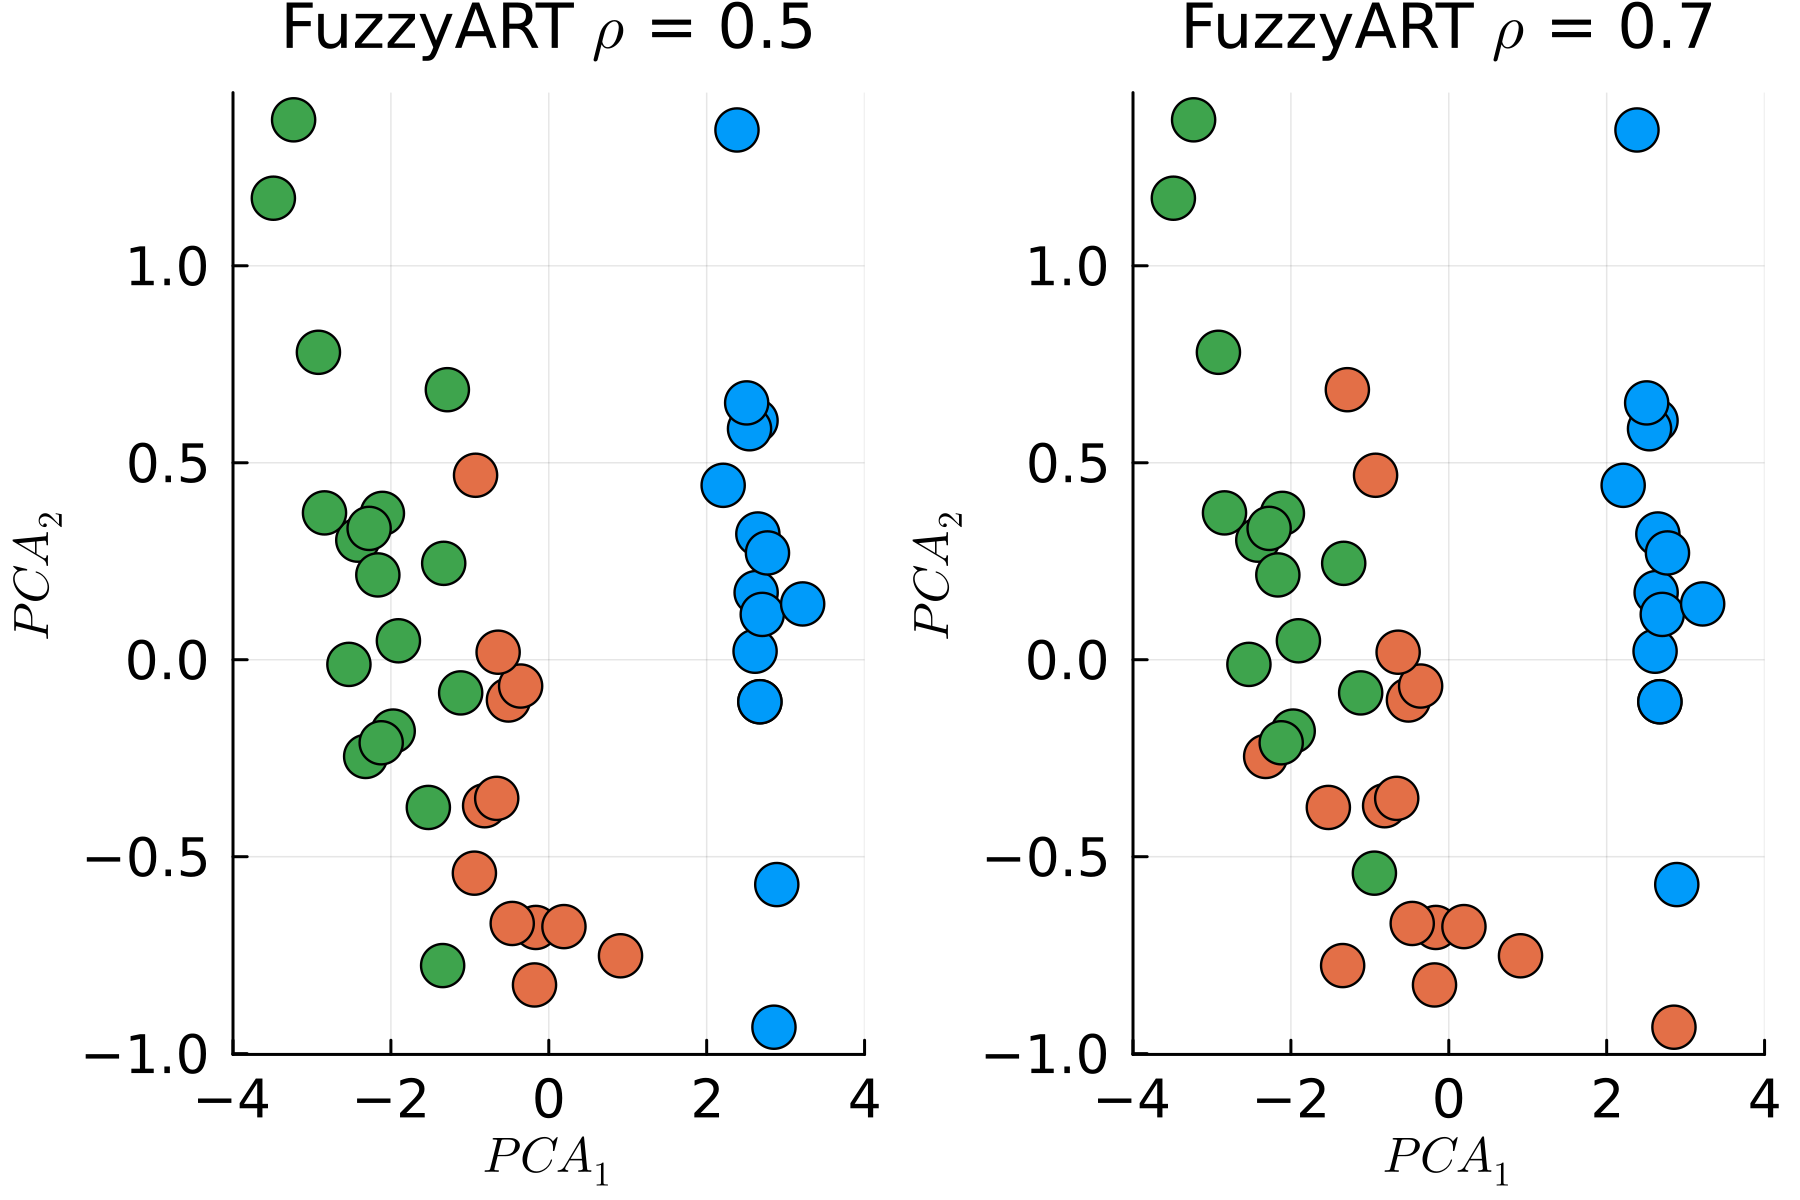

In [19]:
# Create a function for our subplots
function fuzzyart_scatter(data, labels, rho)
    p = scatter(
        data[1, :],             # PCA dimension 1
        data[2, :],             # PCA dimension 2
        group=labels,           # labels belonging to each point
        markersize=8,           # size of scatter points
        xlims = [-4, 4],        # manually set the x-limits
        title=(@sprintf "FuzzyART \$\\rho\$ = %.1f" rho),  # formatted title
    )
    return p
end

# Create the two scatterplot objects
p1 = fuzzyart_scatter(X_test_pca, y_hat_1, rho_1)
p2 = fuzzyart_scatter(X_test_pca, y_hat_2, rho_2)

# Plot the two scatterplots together
plot(
    p1, p2,                 # scatterplot objects
    layout = (1, 2),        # plot side-by-side
    ##layout = [a, b],        # plot side-by-side
    legend = false,         # no legend
    xtickfontsize = 12,     # x-tick size
    ytickfontsize = 12,     # y-tick size
    xlabel = "\$PCA_1\$",   # x-label
    ylabel = "\$PCA_2\$",   # y-label
    dpi = 300,              # Set the dots-per-inch
)

We can see that the two different vigilance values result in similar resutls on the whole, though they differ in how they classify certain samples that straddle the border between

In [20]:
png("assets/options-cover") #hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*